<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/Teresa/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)





In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt


Mounted at /content/drive


## **1. Datasets**

### **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


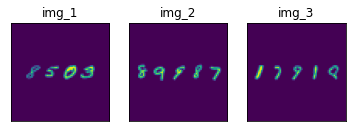

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [2]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

### **1.2 Data Preprocessing**

###**1.2.1 One Hot Encoding**

In [ ]:
#First, perform OHE on training labels
from keras.utils import to_categorical

train_new_labels = to_categorical(train_labels)
Y_train = torch.from_numpy(train_new_labels) #save the oneHotEncoded labels as tensor

In [ ]:
Y_train

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.,

In [ ]:
Y_train.shape

torch.Size([56000, 5, 11])

### **1.2.2 Data Normalization**

In [3]:
# normalize to range 0-1 with typecast to float
def data_normalized(x):
  scaled_x = x.astype('float32') / 255.0
  return scaled_x

scaled_train_images = data_normalized(train_images)
X_train = torch.from_numpy(scaled_train_images)

###**1.2.3 Detecting the number of digits**

In [144]:
import cv2
threshold = 1 #Hyperparameter?
width = 12
height = 12

In [145]:
def findDigits(img):
  #Note that a normalized image does not work
  ret,thresh = cv2.threshold(img,threshold,255,0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #print(len(contours))
  def getKey(item):
    return item[0]

  digitsLoc = []
  minArea = 15
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w == 1 and h > 4:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
    
    elif w * h > minArea:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
  
  return sorted(digitsLoc, key = lambda x: x[0])

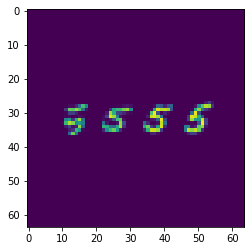

Case#:  264 Detected:  3  Expected:  4
Case#:  1530 Detected:  4  Expected:  5
Case#:  3344 Detected:  1  Expected:  2
Case#:  3709 Detected:  3  Expected:  4
Case#:  4142 Detected:  4  Expected:  5
Case#:  4155 Detected:  3  Expected:  4
Case#:  4757 Detected:  3  Expected:  4
Case#:  5245 Detected:  1  Expected:  2
Case#:  7023 Detected:  4  Expected:  5
Case#:  7348 Detected:  6  Expected:  5
Case#:  7491 Detected:  4  Expected:  5
Case#:  7958 Detected:  5  Expected:  4
Case#:  9140 Detected:  3  Expected:  4
Case#:  10223 Detected:  2  Expected:  3
Case#:  11408 Detected:  2  Expected:  3
Case#:  11739 Detected:  4  Expected:  5
Case#:  12629 Detected:  2  Expected:  3
Case#:  13291 Detected:  3  Expected:  4
Case#:  13551 Detected:  4  Expected:  5
Case#:  16801 Detected:  3  Expected:  4
Case#:  17768 Detected:  6  Expected:  5
Case#:  18127 Detected:  4  Expected:  5
Case#:  20220 Detected:  3  Expected:  4
Case#:  22505 Detected:  1  Expected:  2
Case#:  22884 Detected:  5  Ex

In [ ]:
images_scaled=[]
images_scaled.append(np.array(train_images[4476], dtype='float').reshape(64,64))
sample = plt.imshow(images_scaled[0])
plt.show()

#x = findDigits(train_images[3282])
passed = 0
total = 0

for i in range(0, 56000):
  x = len(findDigits(train_images[i]))
  n = 0
  for c in train_labels[i]:
    if c != 10:
      n = n + 1
  
  if n == x:
    passed = passed + 1
  else:
    print("Case#: ",i, "Detected: " ,x, " Expected: ", n)
  total = total + 1

print(passed/total)

### **1.2.4 Class Distribution**


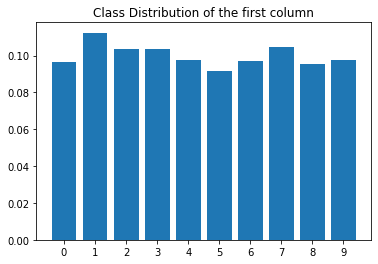

In [ ]:
unique_y1, counts_y1 = np.unique(train_labels[:, 0], return_counts=True)
plt.bar(unique_y1, counts_y1/sum(counts_y1))
plt.xticks(unique_y1, unique_y1)
plt.title(f"Class Distribution of the first column")
plt.show()

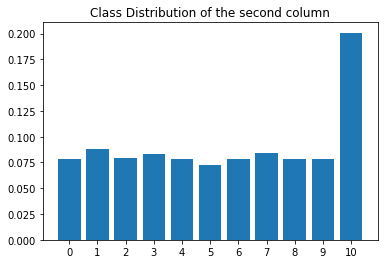

In [ ]:
unique_y2, counts_y2 = np.unique(train_labels[:, 1], return_counts=True)
plt.bar(unique_y2, counts_y2/sum(counts_y2))
plt.xticks(unique_y2, unique_y2)
plt.title(f"Class Distribution of the second column")
plt.show()

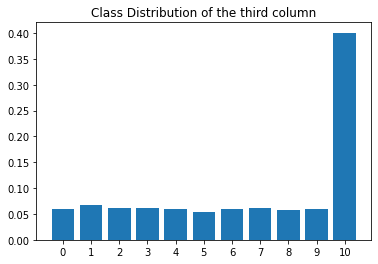

In [ ]:
unique_y3, counts_y3 = np.unique(train_labels[:, 2], return_counts=True)
plt.bar(unique_y3, counts_y3/sum(counts_y3))
plt.xticks(unique_y3, unique_y3)
plt.title(f"Class Distribution of the third column")
plt.show()

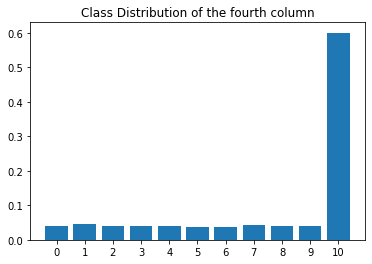

In [ ]:
unique_y4, counts_y4 = np.unique(train_labels[:, 3], return_counts=True)
plt.bar(unique_y4, counts_y4/sum(counts_y4))
plt.xticks(unique_y4, unique_y4)
plt.title(f"Class Distribution of the fourth column")
plt.show()

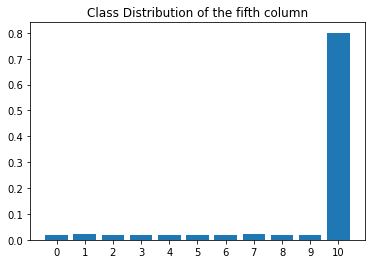

In [ ]:
unique_y5, counts_y5 = np.unique(train_labels[:, 4], return_counts=True)
plt.bar(unique_y5, counts_y5/sum(counts_y5))
plt.xticks(unique_y5, unique_y5)
plt.title(f"Class Distribution of the fifth column")
plt.show()

### **1.2.4 Calculate the bounds of the images**


In [6]:
def lowerBound(x):
  N = x.shape[1]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return min(lowerBounds)
  
def upperBound(x):
  N = x.shape[1]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return max(upperBounds)

In [7]:
def leftBound(x):
  N = x.shape[2]
  D = x.shape[0]
  leftBounds = [0]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, j], bound)):
        leftBounds[i] = j + 1
      else:
        break
  return min(leftBounds)
  
def rightBound(x):
  N = x.shape[2]
  D = x.shape[0]
  rightBounds = [64]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, 63 - j], bound)):
        rightBounds[i] = 63 - j
      else:
        break
  return max(rightBounds)

In [9]:
u = upperBound(X_train)
l = lowerBound(X_train)
l2 = leftBound(X_train)
r = rightBound(X_train)

print("Upper bound: ", u,", Lower bound:", l, ", Left bound: ", l2,", Right bound:", r)

Upper bound:  38 , Lower bound: 26 , Left bound:  2 , Right bound: 62


### **1.2.5 Partitioning the data**


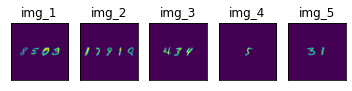

In [ ]:
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[5], dtype='float').reshape(64,64))
titles.append("img_3")
images.append(np.array(train_images[9], dtype='float').reshape(64,64))
titles.append("img_4")
images.append(np.array(train_images[26], dtype='float').reshape(64,64))
titles.append("img_5")

for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

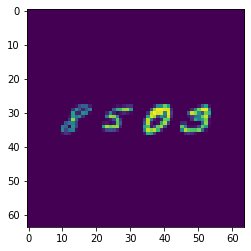

In [10]:
x_try = X_train[0].reshape(64, 64)
#x_try = np.float32(x_try).reshape(64, 64)
plt.imshow(x_try)

In [123]:
def leftBound_digit(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)):
      leftBound = i + 1
    else:
      break
  return leftBound

In [124]:
def rightBound_digit(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)) == False:
      leftBound = i + 1
    else:
      break
  return leftBound

In [125]:
l1_1 = leftBound_digit(x_try, 0)
l1_2 = rightBound_digit(x_try, l1_1)
l2_1 = leftBound_digit(x_try, l1_2)
l2_2 = rightBound_digit(x_try, l2_1)
l3_1 = leftBound_digit(x_try, l2_2)
l3_2 = rightBound_digit(x_try, l3_1)
l4_1 = leftBound_digit(x_try, l3_2)
l4_2 = rightBound_digit(x_try, l4_1)

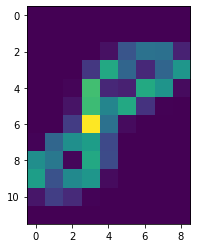

In [126]:
plt.imshow(x_try[26:38 ,l1_1:l1_2])

In [163]:
np.array(x_try[26:38 ,l1_1])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00784314, 0.40392157, 0.45882353,
       0.05098039, 0.        ], dtype=float32)

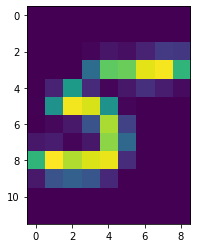

In [128]:
plt.imshow(x_try[26:38 ,l2_1:l2_2])

In [160]:
np.array(x_try[26:38 ,l2_1+1])

array([0.        , 0.        , 0.        , 0.        , 0.08627451,
       0.43529412, 0.01960784, 0.06666667, 0.85490197, 0.21960784,
       0.        , 0.        ], dtype=float32)

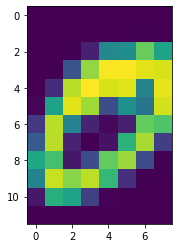

In [129]:
plt.imshow(x_try[26:38 ,l3_1:l3_2])

In [131]:
np.array(x_try[26:38 ,l3_1])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01176471, 0.16470589, 0.28235295, 0.5921569 , 0.44705883,
       0.0627451 , 0.        ], dtype=float32)

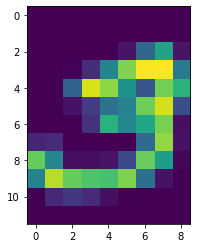

In [132]:
plt.imshow(x_try[26:38 ,l4_1:l4_2])

In [133]:
l5_1 = leftBound_digit(x_try, l4_2)
l5_2 = rightBound_digit(x_try, l5_1)
print(" l5_1: ", l5_1, "l5_2: ", l5_2) #think about how to handle this
'''
if(l == 64 && r == 0):
  the digit = torch.zeros((12, 12))
'''

 l5_1:  64 l5_2:  0


'\nif(l == 64 && r == 0):\n  the digit = torch.zeros((12, 12))\n'

In [ ]:
x_try[26:38,l1_1:l1_2].shape

torch.Size([12, 10])

In [ ]:
x_try1 = torch.zeros((12, 12))
x_try1[0:12, 0: x_try[26:38,l1_1:l1_2].shape[1]] = x_try[26:38,l1_1:l1_2]

In [ ]:
x_try2 = torch.zeros((12, 12))
x_try2[0:12, 0: x_try[26:38,l2_1:l2_2].shape[1]] = x_try[26:38,l2_1:l2_2]

In [ ]:
x_try3 = torch.zeros((12, 12))
x_try3[0:12, 0: x_try[26:38,l3_1:l3_2].shape[1]] = x_try[26:38,l3_1:l3_2]

In [ ]:
x_try4 = torch.zeros((12, 12))
x_try4[0:12, 0: x_try[26:38,l4_1:l4_2].shape[1]] = x_try[26:38,l4_1:l4_2]

In [ ]:
x_try5 = torch.zeros((12, 12))

In [ ]:
x_try0 = torch.stack((x_try1, x_try2, x_try3, x_try4, x_try5))
x_try0.shape

torch.Size([5, 12, 12])

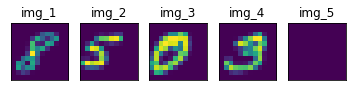

In [ ]:
for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(x_try0[i, :, :])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

In [134]:
def partition_image(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  x_1 = torch.zeros((14, 14))
  x_1[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    x_2 = torch.zeros((14, 14))
    x_3 = torch.zeros((14, 14))
    x_4 = torch.zeros((14, 14))
    x_5 = torch.zeros((14, 14))
  else:
    r = rightBound_digit(x, l)
    x_2 = torch.zeros((14, 14))
    x_2[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      x_3 = torch.zeros((14, 14))
      x_4 = torch.zeros((14, 14))
      x_5 = torch.zeros((14, 14))
    else:
      r = rightBound_digit(x, l)
      x_3 = torch.zeros((14, 14))
      x_3[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        x_4 = torch.zeros((14, 14))
        x_5 = torch.zeros((14, 14))
      else:
        r = rightBound_digit(x, l)
        x_4 = torch.zeros((14, 14))
        x_4[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          x_5 = torch.zeros((14, 14))
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          x_5 = torch.zeros((14, 14))
          x_5[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
    
  x_0 = torch.stack((x_1, x_2, x_3, x_4, x_5))

  return x_0

In [135]:
#this code checks the accuracy per image
def partition_image_number_of_digits_accuracy(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    n = 1
  else:
    r = rightBound_digit(x, l)
    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      n = 2
    else:
      r = rightBound_digit(x, l)
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        n = 3
      else:
        r = rightBound_digit(x, l)
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          n = 4
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          n = 5
  return n

In [136]:
def accuracy_check(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = 0
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect = incorrect +1
  return correct/(incorrect+correct)

In [137]:
accuracy_check(X_train, train_labels)

0.997375

In [ ]:
#The accuracy is 0.994 when set threshold = 0
#The accuracy is 0.996 when set threshold = 0.25

In [138]:
def incorrect_list(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = []
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect.append(i)
  return incorrect

In [139]:
incorrect_digits = incorrect_list(X_train, train_labels)

In [151]:
print(np.array(incorrect_digits))

[  678  1576  2110  3254  3771  3878  3883  4011  4447  4639  4890  5011
  5809  5892  6708  7021  8597  8698  8941  9070  9722  9860 10545 10792
 11090 11622 12806 13824 14131 14150 14748 14896 15874 16268 16488 16553
 16984 17030 17310 18127 18772 18861 19104 19660 20243 20666 21407 21578
 21692 21839 21917 22832 22864 23438 24124 24360 24786 24809 25190 25273
 25292 25376 25913 26042 26601 27695 27704 27942 28690 28919 29189 29444
 29616 29623 29800 30120 30169 30386 30907 31392 31598 32187 32383 32557
 32752 32944 33049 33167 33354 34909 35422 36550 36780 36787 37239 37607
 37859 38355 38495 38753 38965 39331 39693 40349 40780 40917 41084 41329
 41479 41913 42324 42451 43557 44071 44245 44650 45009 45074 45089 45187
 45719 46256 46543 46742 47255 47595 48072 48985 49179 49303 49305 50225
 50737 50840 51106 51592 52326 52705 53779 54048 54282 54814 54831 55088
 55823 55847 55849]


In [152]:
digits = []
passed = 0
for i in range(0, 56000):
  x = len(findDigits(train_images[i]))
  n = 0
  for c in train_labels[i]:
    if c != 10:
      n = n + 1
  
  if n == x:
    passed = passed + 1
  else:
    digits.append(i)

print(np.array(digits))

[  264  1530  3344  3709  4142  4155  4757  5245  7023  7348  7491  7958
  9140 10223 11408 11739 12629 13291 13551 16801 17768 18127 20220 22505
 22884 23959 26042 27399 28246 29910 31619 32954 33640 33935 35350 37873
 39165 39721 41435 42162 42649 44362 46295 46373 48651 49483 50935 53330
 54436 55359]


In [156]:
bad_cases = []
for i in list(range(0, np.array(incorrect_digits).shape[0])):
  for j in list(range(0, np.array(digits).shape[0])):
    if np.array(incorrect_digits)[i] == np.array(digits)[j]:
      bad_cases.append(np.array(digits)[j])

In [157]:
print(np.array(bad_cases))

[18127 26042]


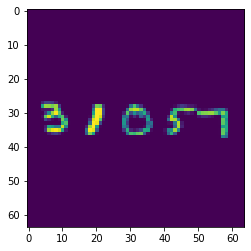

In [158]:
plt.imshow(X_train[18127].reshape(64, 64))

In [171]:
np.array(X_train[18127][26:38, 49])

array([[0.        ],
       [0.        ],
       [0.03529412],
       [0.36078432],
       [0.00392157],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [166]:
np.array(X_train[18127][26:38, 50])

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.05882353],
       [0.7058824 ],
       [0.05882353],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

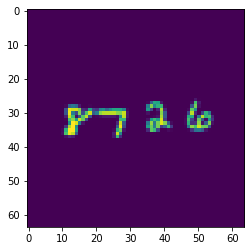

In [159]:
plt.imshow(X_train[26042].reshape(64, 64))

In [172]:
def leftBound_digit_1(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.361)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)):
      leftBound = i + 1
    else:
      break
  return leftBound


def rightBound_digit_1(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.361)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)) == False:
      leftBound = i + 1
    else:
      break
  return leftBound

def partition_image_number_of_digits_accuracy_1(x):
  x = x.reshape(64, 64)
  l = leftBound_digit_1(x, 0)
  r = rightBound_digit_1(x, l)
  l = leftBound_digit_1(x, r)
  if l == 64: #i.e. one digit
    n = 1
  else:
    r = rightBound_digit_1(x, l)
    l = leftBound_digit_1(x, r)

    if l == 64: #i.e. two digits
      n = 2
    else:
      r = rightBound_digit_1(x, l)
      l = leftBound_digit_1(x, r)

      if l == 64: #i.e. three digits
        n = 3
      else:
        r = rightBound_digit_1(x, l)
        l = leftBound_digit_1(x, r)

        if l == 64:  #i.e. four digits
          n = 4
        else: #i.e. five digits
          r = rightBound_digit_1(x, l)
          n = 5
  return n

def accuracy_check_1(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = 0
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy_1(x[i]):
      correct = correct + 1
    else:
      incorrect = incorrect +1
  return correct/(incorrect+correct)


In [173]:
accuracy_check_1(X_train, train_labels)

0.9857142857142858

In [174]:
def dataset_images_partition(x):
  D = x.shape[0]
  X_new = []
  for i in list(range(0, D)):
    X_new.append(partition_image(x[i]))
  return X_new

In [175]:
dataset_images_partition(X_train)

RuntimeError: ignored

In [ ]:
#The above runtime error occur because some of the digits fail to be separated.

## **2. Neural Network Models**

In [ ]:
#classification
#subset data into groups

from sklearn.model_selection import KFold
cross_validation = KFold(n_splits=5)
#cross_validation.split(X, y=None, groups=None)

In [ ]:
'''
logistic: https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19
clustering: https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/ 
'''

## **3. Performance**

## **4. Application to the Testing Images**